In [1]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())  # Check if CUDA is available (if applicable)

2.7.0
False


In [2]:
import torch
import tqdm
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import cv2
import torchvision
from torchvision import datasets, models, transforms
from torchvision.transforms import v2
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import time
import os
import PIL
from PIL import Image
cudnn.benchmark = True


device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


In [3]:
BASE_DIR = "Desktop/ResearchAlzheimers/Alzheimer MRI Disease Classification Dataset/Data"
disease_label_from_category = {
    0: "Mild Demented",
    1: "Moderate Demented",
    2: "Non Demented",
    3: "Very Mild Demented",
}

In [4]:
df = pd.read_parquet("/Users/jessicakammann/Desktop/Alzheimer2/CompetitingTechnologies/Desktop/ResearchAlzheimers/Alzheimer MRI Disease Classification Dataset/Data/train-00000-of-00001-c08a401c53fe5312.parquet", engine="pyarrow")
df.head()

,image,label
0,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,2
1,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,0
2,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,3
3,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,3
4,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,2


In [5]:
test = pd.read_parquet("/Users/jessicakammann/Desktop/ResearchAlzheimers/Alzheimer MRI Disease Classification Dataset/Data/test-00000-of-00001-44110b9df98c5585.parquet", engine="pyarrow")

In [6]:
def dict_to_image(image_dict):
    if isinstance(image_dict, dict) and 'bytes' in image_dict:
        byte_string = image_dict['bytes']
        nparr = np.frombuffer(byte_string, np.uint8)
        img = cv2.imdecode(nparr, cv2.IMREAD_GRAYSCALE)
        return img
    else:
        raise TypeError(f"Expected dictionary with 'bytes' key, got {type(image_dict)}")
    #takes it out of parquet format into an image format

In [7]:
df['img_arr'] = df['image'].apply(dict_to_image)
df.drop("image", axis=1, inplace=True)
df.head()

,label,img_arr
0,2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


In [8]:
test['img_arr'] = test['image'].apply(dict_to_image)
test.drop("image", axis=1, inplace=True)

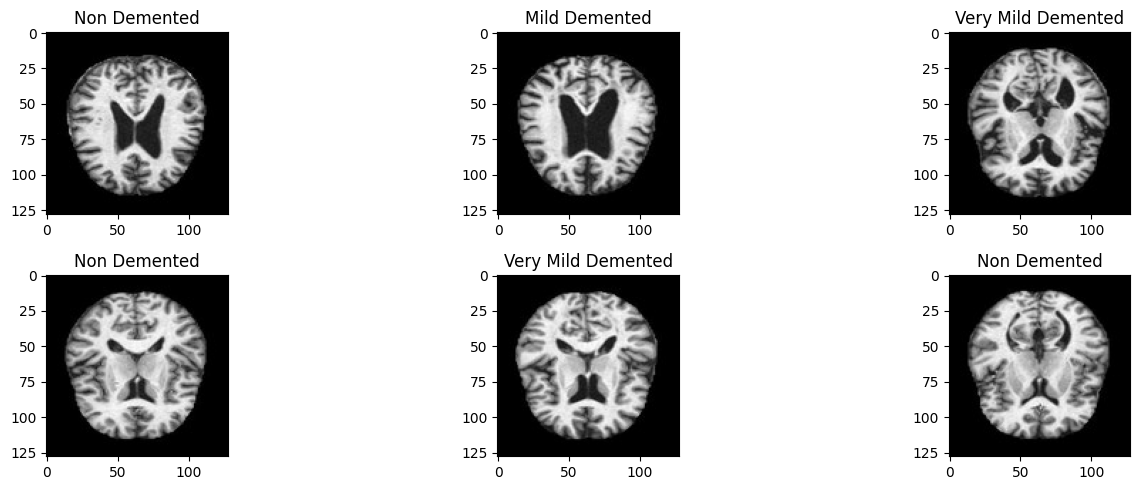

In [9]:
# Check we can actually render the image and that it looks reasonable
fig, ax = plt.subplots(2, 3, figsize=(15, 5))
axs = ax.flatten()
for axes in axs:
    rand = np.random.randint(0, len(df))
    axes.imshow(df.iloc[rand]['img_arr'], cmap="gray")
    axes.set_title(disease_label_from_category[df.iloc[rand]['label']])
plt.tight_layout()
plt.show()

In [10]:
class ImageDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe
        
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        image = self.dataframe.iloc[idx]["img_arr"] # Get the label from the df
        label = self.dataframe.iloc[idx]["label"] # Get the img numpy array from the df
        # The CNN requires we add a channel dimension i.e. (128, 128) -> (1, 128, 128)
        image = torch.tensor(image, dtype=torch.float32).unsqueeze(0)
        label = torch.tensor(label, dtype=torch.long)
        return image, label

In [11]:
#Turn it into a PyTorch File
# Create dataset and dataloader
batch_size= 32
train_dataset = ImageDataset(df)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = ImageDataset(test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [12]:
#CNN
class simpleCNN(nn.Module):
    def __init__(self):
        super(simpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(32 * 32 * 32, 128)  # Adjusted for input size
        self.fc2 = nn.Linear(128, 4)  # 4 classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 32 * 32)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
    #Training Loop
    
    #Validation Loop 
    

In [13]:
   #Training Loop
def train_model(model, train_loader, criterion, optimizer, num_epochs=10):
        model.train()
        for epoch in range(num_epochs):
            running_loss = 0.0
            for images, labels in tqdm.tqdm(train_loader):
                images = images.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()

            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")
        return model
    
    #Validation Loop 
def validate_model(model, test_loader, criterion):
        model.eval()
        running_loss = 0.0
        all_labels = []
        all_preds = []
        
        with torch.no_grad():
            for images, labels in tqdm.tqdm(test_loader):
                images = images.to(device)
                labels = labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)
                running_loss += loss.item()

                _, preds = torch.max(outputs, 1)
                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(preds.cpu().numpy())

        accuracy = accuracy_score(all_labels, all_preds)
        print(f"Validation Loss: {running_loss/len(test_loader):.4f}, Accuracy: {accuracy:.4f}")
        return accuracy

In [14]:
model = simpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 10
trained_model = train_model(model, train_loader, criterion, optimizer, num_epochs)
accuracy = validate_model(trained_model, test_loader, criterion)
# Save the model
torch.save(trained_model.state_dict(), "simple_cnn_model.pth")
# Load the model
loaded_model = simpleCNN().to(device)
loaded_model.load_state_dict(torch.load("simple_cnn_model.pth"))
loaded_model.eval()
# Test the loaded model
test_accuracy = validate_model(loaded_model, test_loader, criterion)
# Generate classification report
def generate_classification_report(model, test_loader):
    model.eval()
    all_labels = []
    all_preds = []
    
    with torch.no_grad():
        for images, labels in tqdm.tqdm(test_loader):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    print(classification_report(all_labels, all_preds, target_names=disease_label_from_category.values()))
generate_classification_report(loaded_model, test_loader)


100%|██████████| 160/160 [00:07<00:00, 22.26it/s]


Epoch [1/10], Loss: 6.2631


100%|██████████| 160/160 [00:03<00:00, 46.67it/s]


Epoch [2/10], Loss: 0.8276


100%|██████████| 160/160 [00:03<00:00, 45.52it/s]


Epoch [3/10], Loss: 0.6612


100%|██████████| 160/160 [00:03<00:00, 45.90it/s]


Epoch [4/10], Loss: 0.5588


100%|██████████| 160/160 [00:03<00:00, 49.64it/s]


Epoch [5/10], Loss: 0.4109


100%|██████████| 160/160 [00:03<00:00, 49.58it/s]


Epoch [6/10], Loss: 0.3023


100%|██████████| 160/160 [00:03<00:00, 49.89it/s]


Epoch [7/10], Loss: 0.2478


100%|██████████| 160/160 [00:03<00:00, 49.90it/s]


Epoch [8/10], Loss: 0.1602


100%|██████████| 160/160 [00:03<00:00, 51.06it/s]


Epoch [9/10], Loss: 0.1188


100%|██████████| 160/160 [00:03<00:00, 51.89it/s]


Epoch [10/10], Loss: 0.1011


100%|██████████| 40/40 [00:00<00:00, 67.30it/s]


Validation Loss: 0.4563, Accuracy: 0.8523


100%|██████████| 40/40 [00:00<00:00, 108.63it/s]


Validation Loss: 0.4563, Accuracy: 0.8523


100%|██████████| 40/40 [00:00<00:00, 82.92it/s] 

                    precision    recall  f1-score   support

     Mild Demented       0.96      0.72      0.82       172
 Moderate Demented       1.00      0.87      0.93        15
      Non Demented       0.83      0.96      0.89       634
Very Mild Demented       0.85      0.75      0.80       459

          accuracy                           0.85      1280
         macro avg       0.91      0.83      0.86      1280
      weighted avg       0.86      0.85      0.85      1280

